In [55]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [57]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Powershell,417.735188,83.547038,5
Todd Ideas,722.517687,48.167846,15
PEP 8,1286.716750,160.839594,8
SharePoint,1478.637942,123.219829,12
Terraform,1658.899944,66.355998,25
Azure Functions + Visual Studio,1749.849693,124.989264,14
IW Migration,1924.487429,137.463388,14
FSLogix,2036.494942,84.853956,24
Open Source/GitHub,2044.397596,127.774850,16
Email Auth and Security,2174.901142,167.300088,13


# Histogram

82973.67


<Axes: >

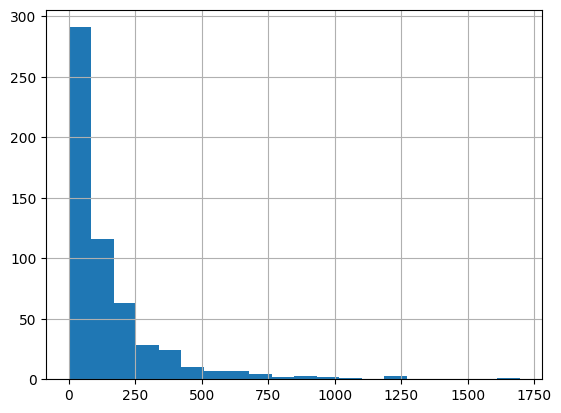

In [58]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [59]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [60]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [61]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [62]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [63]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [64]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [65]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [66]:
# n=10
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [67]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [68]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [69]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 562


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
106,Powershell,error during connect\nIndicates the Docker CLI...,fa14e849210808f8bf87d29005622d6d,-233.083019,-83.547038,233.083019,417.735188,0.476955,5,0,0
110,Powershell,NUL\nA virtual file in Windows that discards w...,eb95bc3e9d7175749fa85f045565d15f,-98.997500,-83.547038,233.083019,417.735188,0.476955,5,1,0
108,Powershell,Get-Service\nDisplays the status of Windows se...,61dbfe3e3fd4becf9c271f621539b52a,-66.850283,-83.547038,233.083019,417.735188,0.476955,5,2,0
109,Powershell,-Force\nOverrides warnings or confirmation pro...,6d7a53df80e0774571798b7e4c583afe,-14.810752,-83.547038,233.083019,417.735188,0.476955,5,3,0
107,Powershell,az\nThe Azure CLI command-line tool for managi...,9376de9d5b22a60393b68271da0c480e,-3.993634,-83.547038,233.083019,417.735188,0.476955,5,4,0
53,PEP 8,Use Parentheses for Multi-Line Imports: When i...,b2d69c860e3a1150436c552d740b2aa6,-572.291381,-160.839594,572.291381,1286.716750,0.142926,8,0,0
51,PEP 8,One Import Per Line: Place each import stateme...,510a6ed6e688465b274d1e07eb0ae246,-187.432125,-160.839594,572.291381,1286.716750,0.142926,8,1,0
52,PEP 8,Prevent Circular Imports: Avoid scenarios wher...,83d6663484104f7621d02d4be77e3d89,-121.031365,-160.839594,572.291381,1286.716750,0.142926,8,2,0
172,PEP 8,Spaces Around Assignment Operators: Use spaces...,8f3054071b8a4967c311ba46c8feea17,-104.014889,-160.839594,572.291381,1286.716750,0.142926,8,3,0
55,PEP 8,Prefer Absolute Imports: Use full paths for im...,03079d188b068f5ee4f7d0ee2596bb63,-100.752938,-160.839594,572.291381,1286.716750,0.142926,8,4,0



## Random

In [70]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [71]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
106,Powershell,error during connect\nIndicates the Docker CLI...,fa14e849210808f8bf87d29005622d6d,-233.083019,-83.547038,233.083019,417.735188,0.476955,5,0,0
110,Powershell,NUL\nA virtual file in Windows that discards w...,eb95bc3e9d7175749fa85f045565d15f,-98.997500,-83.547038,233.083019,417.735188,0.476955,5,1,0
108,Powershell,Get-Service\nDisplays the status of Windows se...,61dbfe3e3fd4becf9c271f621539b52a,-66.850283,-83.547038,233.083019,417.735188,0.476955,5,2,0
109,Powershell,-Force\nOverrides warnings or confirmation pro...,6d7a53df80e0774571798b7e4c583afe,-14.810752,-83.547038,233.083019,417.735188,0.476955,5,3,0
107,Powershell,az\nThe Azure CLI command-line tool for managi...,9376de9d5b22a60393b68271da0c480e,-3.993634,-83.547038,233.083019,417.735188,0.476955,5,4,0
53,PEP 8,Use Parentheses for Multi-Line Imports: When i...,b2d69c860e3a1150436c552d740b2aa6,-572.291381,-160.839594,572.291381,1286.716750,0.142926,8,0,0
51,PEP 8,One Import Per Line: Place each import stateme...,510a6ed6e688465b274d1e07eb0ae246,-187.432125,-160.839594,572.291381,1286.716750,0.142926,8,1,0
52,PEP 8,Prevent Circular Imports: Avoid scenarios wher...,83d6663484104f7621d02d4be77e3d89,-121.031365,-160.839594,572.291381,1286.716750,0.142926,8,2,0
172,PEP 8,Spaces Around Assignment Operators: Use spaces...,8f3054071b8a4967c311ba46c8feea17,-104.014889,-160.839594,572.291381,1286.716750,0.142926,8,3,0
55,PEP 8,Prefer Absolute Imports: Use full paths for im...,03079d188b068f5ee4f7d0ee2596bb63,-100.752938,-160.839594,572.291381,1286.716750,0.142926,8,4,0


In [72]:
existing_cards['age'].mean()

-147.63999011172422